Вариант: Список людей. 

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    precision_score, recall_score, accuracy_score, roc_auc_score, f1_score,
    matthews_corrcoef, cohen_kappa_score, confusion_matrix
)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import featuretools as ft
from sklearn.metrics import accuracy_score, classification_report

# Функция для применения oversampling
def apply_oversampling(X, y):
    oversampler = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = oversampler.fit_resample(X, y)
    return X_resampled, y_resampled

# Функция для применения undersampling
def apply_undersampling(X, y):
    undersampler = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = undersampler.fit_resample(X, y)
    return X_resampled, y_resampled

def split_stratified_into_train_val_test(
    df_input,
    stratify_colname="y",
    frac_train=0.6,
    frac_val=0.15,
    frac_test=0.25,
    random_state=None,
):
    """
    Splits a Pandas dataframe into three subsets (train, val, and test)
    following fractional ratios provided by the user, where each subset is
    stratified by the values in a specific column (that is, each subset has
    the same relative frequency of the values in the column). It performs this
    splitting by running train_test_split() twice.

    Parameters
    ----------
    df_input : Pandas dataframe
        Input dataframe to be split.
    stratify_colname : str
        The name of the column that will be used for stratification. Usually
        this column would be for the label.
    frac_train : float
    frac_val   : float
    frac_test  : float
        The ratios with which the dataframe will be split into train, val, and
        test data. The values should be expressed as float fractions and should
        sum to 1.0.
    random_state : int, None, or RandomStateInstance
        Value to be passed to train_test_split().

    Returns
    -------
    df_train, df_val, df_test :
        Dataframes containing the three splits.
    """

    if frac_train + frac_val + frac_test != 1.0:
        raise ValueError(
            "fractions %f, %f, %f do not add up to 1.0"
            % (frac_train, frac_val, frac_test)
        )

    if stratify_colname not in df_input.columns:
        raise ValueError("%s is not a column in the dataframe" % (stratify_colname))

    X = df_input  # Contains all columns.
    y = df_input[
        [stratify_colname]
    ]  # Dataframe of just the column on which to stratify.

    # Split original dataframe into train and temp dataframes.
    df_train, df_temp, y_train, y_temp = train_test_split(
        X, y, stratify=y, test_size=(1.0 - frac_train), random_state=random_state
    )

    # Split the temp dataframe into val and test dataframes.
    relative_frac_test = frac_test / (frac_val + frac_test)
    df_val, df_test, y_val, y_test = train_test_split(
        df_temp,
        y_temp,
        stratify=y_temp,
        test_size=relative_frac_test,
        random_state=random_state,
    )

    assert len(df_input) == len(df_train) + len(df_val) + len(df_test)

    return df_train, df_val, df_test


df = pd.read_csv("../data/age.csv", nrows=10000)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Id                 10000 non-null  object 
 1   Name               10000 non-null  object 
 2   Short description  9996 non-null   object 
 3   Gender             9927 non-null   object 
 4   Country            9721 non-null   object 
 5   Occupation         9836 non-null   object 
 6   Birth year         10000 non-null  int64  
 7   Death year         9999 non-null   float64
 8   Manner of death    1893 non-null   object 
 9   Age of death       9999 non-null   float64
dtypes: float64(2), int64(1), object(7)
memory usage: 781.4+ KB


Как бизнес-цели выделим следующие 2 варианта:
    1) GameDev. Создание игры про конкретного персонажа, живущего в конкретном временном промежутке в конкретной стране. 
    2) Исследование зависимости длительности жизни от страны проживания.
    
Поскольку именно эти бизнес-цели были выбраны в предыдущей лабораторной работе, будем их использовать.
Но возникает проблема с 1 целью: её невозможно использовать для задачи классификации. Заменим ее на классификацию людей по возрастным группам, что может быть полезно для рекламных целей.

Выполним подготовку данных

In [46]:
df.fillna({"Gender": "NaN", "Country": "NaN", "Occupation" : "NaN", "Manner of death" : "NaN"}, inplace=True)
df = df.dropna()
df['Country'] = df['Country'].str.split('; ')
df = df.explode('Country')
data = df.copy()

value_counts = data["Country"].value_counts()
rare = value_counts[value_counts < 100].index
data = data[~data["Country"].isin(rare)]

data.drop(data[~data['Gender'].isin(['Male', 'Female'])].index, inplace=True)

data1 = pd.get_dummies(data, columns=['Gender', 'Country', 'Occupation'], drop_first=True)

Определить достижимый уровень качества модели для каждой задачи. На основе имеющихся данных уровень качества моделей не будет высоким, поскольку все таки длительность жизни лишь примерная и точно ее угадать невозможно.

Выберем ориентиры для наших 2х задач:
    1)Регрессии - средний возраст человека
    2)Классификации - аиболее часто встречающаяся возрастная группа

Построим конвейер.

In [33]:
print(data.columns)


Index(['Id', 'Name', 'Short description', 'Birth year', 'Death year',
       'Age of death', 'Gender_Male', 'Country_France',
       'Country_German Confederation', 'Country_German Democratic Republic',
       ...
       'Manner of death_euthanasia', 'Manner of death_homicide',
       'Manner of death_homicide; natural causes',
       'Manner of death_internal bleeding', 'Manner of death_natural causes',
       'Manner of death_suicide',
       'Manner of death_suicide; homicide; accident',
       'Manner of death_suicide; unfortunate accident',
       'Manner of death_summary execution', 'Manner of death_unnatural death'],
      dtype='object', length=400)


In [37]:
X_reg = data1.drop(['Id', 'Name', 'Age of death', 'Short description', 'Manner of death'], axis=1)
y_reg = data1['Age of death']

# Разделение данных
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Выбор моделей для регрессии
models_reg = {
    'Linear Regression': LinearRegression(),
    'Random Forest Regressor': RandomForestRegressor(random_state=42),
    'Gradient Boosting Regressor': GradientBoostingRegressor(random_state=42)
}

# Создание конвейера для регрессии
pipelines_reg = {}
for name, model in models_reg.items():
    pipelines_reg[name] = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])

# Определение сетки гиперпараметров для регрессии
param_grids_reg = {
    'Linear Regression': {},
    'Random Forest Regressor': {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [None, 10, 20, 30]
    },
    'Gradient Boosting Regressor': {
        'model__n_estimators': [100, 200, 300],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 5, 7]
    }
}

# Настройка гиперпараметров для регрессии
best_models_reg = {}
for name, pipeline in pipelines_reg.items():
    grid_search = GridSearchCV(pipeline, param_grids_reg[name], cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train_reg, y_train_reg)
    best_models_reg[name] = grid_search.best_estimator_
    print(f'Best parameters for {name}: {grid_search.best_params_}')

# Обучение моделей и оценка качества
for model_name in best_models_reg.keys():
    print(f"Model: {model_name}")
    model = best_models_reg[model_name]["model"]

    model_pipeline = Pipeline([("scaler", StandardScaler()), ("model", model)])
    model_pipeline = model_pipeline.fit(X_train_reg, y_train_reg)

    y_train_predict = model_pipeline.predict(X_train_reg)
    y_test_predict = model_pipeline.predict(X_test_reg)

    best_models_reg[model_name]["pipeline"] = model_pipeline
    best_models_reg[model_name]["preds_train"] = y_train_predict
    best_models_reg[model_name]["preds_test"] = y_test_predict

    best_models_reg[model_name]["MSE_train"] = mean_squared_error(y_train_reg, y_train_predict)
    best_models_reg[model_name]["MSE_test"] = mean_squared_error(y_test_reg, y_test_predict)
    best_models_reg[model_name]["R2_train"] = r2_score(y_train_reg, y_train_predict)
    best_models_reg[model_name]["R2_test"] = r2_score(y_test_reg, y_test_predict)
    best_models_reg[model_name]["MAE_train"] = mean_absolute_error(y_train_reg, y_train_predict)
    best_models_reg[model_name]["MAE_test"] = mean_absolute_error(y_test_reg, y_test_predict)

Best parameters for Linear Regression: {}
Best parameters for Random Forest Regressor: {'model__max_depth': None, 'model__n_estimators': 100}
Best parameters for Gradient Boosting Regressor: {'model__learning_rate': 0.2, 'model__max_depth': 7, 'model__n_estimators': 300}
Linear Regression: MSE = 0.002807184047660083, R2 = 0.9999899555289343
Random Forest Regressor: MSE = 11.46917740409879, R2 = 0.9589617856804076
Gradient Boosting Regressor: MSE = 8.202651735797296, R2 = 0.9706498410424512


In [50]:
data2 = data.drop(['Short description', 'Manner of death', 'Gender', 'Country', 'Occupation'], axis=1)

In [64]:
# Создание возрастных групп
bins = [0, 18, 30, 50, 70, 100]
labels = ['0-18', '19-30', '31-50', '51-70', '71+']
data['Age Group'] = pd.cut(data['Age of death'], bins=bins, labels=labels)

# Выбор признаков и целевой переменной для классификации
X_class = data2.drop(['Id', 'Name', 'Age of death', 'Age Group'], axis=1)
y_class = data['Age Group']  
print(X_class.columns)
# Разделение данных
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

# Выбор моделей для классификации
models_class = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=5000, solver='liblinear'),
    'Random Forest Classifier': RandomForestClassifier(random_state=42),
    'Gradient Boosting Classifier': GradientBoostingClassifier(random_state=42)
}

# Создание конвейера для классификации
pipelines_class = {}
for name, model in models_class.items():
    pipelines_class[name] = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])

# Определение сетки гиперпараметров для классификации
'''
param_grids_class = {
    'Logistic Regression': {
        'model__C': [0.1, 1, 10],
        'model__solver': ['lbfgs', 'liblinear']
    },
    'Random Forest Classifier': {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [None, 10, 20, 30]
    },
    'Gradient Boosting Classifier': {
        'model__n_estimators': [100, 200, 300],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 5, 7]
    }
}'''
# Убрал определение параметров поскольку уже был предподсчет данных, но вылетела ошибка. Сохранил лучшие параметры

param_grids_class = {
    'Logistic Regression': {
        'model__C': [10],
        'model__solver': ['lbfgs']
    },
    'Random Forest Classifier': {
        'model__n_estimators': [200],
        'model__max_depth': [ 30]
    },
    'Gradient Boosting Classifier': {
        'model__n_estimators': [200],
        'model__learning_rate': [0.1],
        'model__max_depth': [7]
    }
}

# Настройка гиперпараметров для классификации
best_models_class = {}
for name, pipeline in pipelines_class.items():
    grid_search = GridSearchCV(pipeline, param_grids_class[name], cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_class, y_train_class)
    best_models_class[name] = {"model": grid_search.best_estimator_}
    print(f'Best parameters for {name}: {grid_search.best_params_}')

# Обучение моделей и оценка качества
for model_name in best_models_class.keys():
    print(f"Model: {model_name}")
    model = best_models_class[model_name]["model"]

    model_pipeline = Pipeline([("scaler", StandardScaler()), ("model", model)])
    model_pipeline = model_pipeline.fit(X_train_class, y_train_class)

    y_train_predict = model_pipeline.predict(X_train_class)
    y_test_probs = model_pipeline.predict_proba(X_test_class)
    y_test_predict = model_pipeline.predict(X_test_class)

    best_models_class[model_name]["pipeline"] = model_pipeline
    best_models_class[model_name]["probs"] = y_test_probs
    best_models_class[model_name]["preds"] = y_test_predict

    best_models_class[model_name]["Precision_train"] = precision_score(y_train_class, y_train_predict, average='weighted')
    best_models_class[model_name]["Precision_test"] = precision_score(y_test_class, y_test_predict, average='weighted')
    best_models_class[model_name]["Recall_train"] = recall_score(y_train_class, y_train_predict, average='weighted')
    best_models_class[model_name]["Recall_test"] = recall_score(y_test_class, y_test_predict, average='weighted')
    best_models_class[model_name]["Accuracy_train"] = accuracy_score(y_train_class, y_train_predict)
    best_models_class[model_name]["Accuracy_test"] = accuracy_score(y_test_class, y_test_predict)
    best_models_class[model_name]["ROC_AUC_test"] = roc_auc_score(y_test_class, y_test_probs, multi_class='ovr')
    best_models_class[model_name]["F1_train"] = f1_score(y_train_class, y_train_predict, average='weighted')
    best_models_class[model_name]["F1_test"] = f1_score(y_test_class, y_test_predict, average='weighted')
    best_models_class[model_name]["MCC_test"] = matthews_corrcoef(y_test_class, y_test_predict)
    best_models_class[model_name]["Cohen_kappa_test"] = cohen_kappa_score(y_test_class, y_test_predict)
    best_models_class[model_name]["Confusion_matrix"] = confusion_matrix(y_test_class, y_test_predict)

Index(['Birth year', 'Death year'], dtype='object')
Best parameters for Logistic Regression: {'model__C': 10, 'model__solver': 'lbfgs'}
Best parameters for Random Forest Classifier: {'model__max_depth': 30, 'model__n_estimators': 200}
Best parameters for Gradient Boosting Classifier: {'model__learning_rate': 0.1, 'model__max_depth': 7, 'model__n_estimators': 200}
Model: Logistic Regression


c:\Users\89176\sourse\MII\Labas\AIM-PIbd-31-Kozyrev-S-S\aimvenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\89176\sourse\MII\Labas\AIM-PIbd-31-Kozyrev-S-S\aimvenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: Random Forest Classifier
Model: Gradient Boosting Classifier


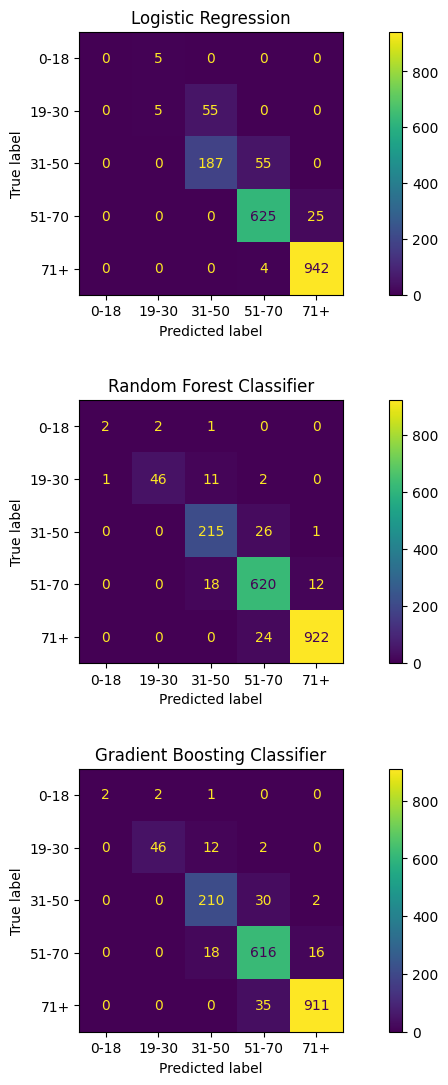

In [67]:
num_models = len(best_models_class)
fig, ax = plt.subplots(num_models, 1, figsize=(12, 10), sharex=False, sharey=False)
for index, key in enumerate(best_models_class.keys()):
    c_matrix = best_models_class[key]["Confusion_matrix"]
    disp = ConfusionMatrixDisplay(
        confusion_matrix=c_matrix, display_labels=["0-18", "19-30", "31-50", "51-70", "71+"]
    ).plot(ax=ax.flat[index])
    disp.ax_.set_title(key)

plt.subplots_adjust(top=1, bottom=0, hspace=0.4, wspace=0.1)
plt.show()

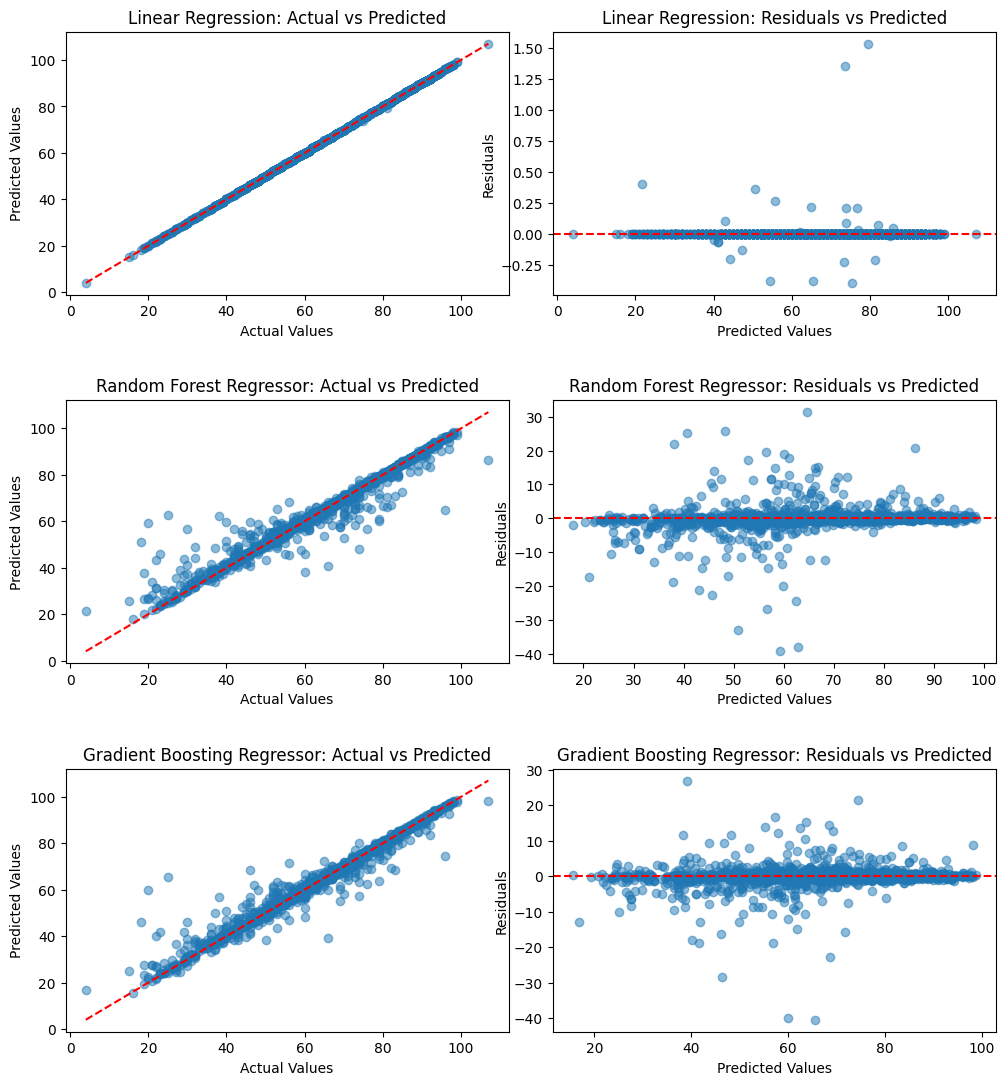

In [78]:
_, ax = plt.subplots(3, 2, figsize=(12, 10), sharex=False, sharey=False)
ax = ax.flatten()

for index, (name, model) in enumerate(best_models_reg.items()):
    y_pred_reg = model.predict(X_test_reg)

    # График фактических значений против предсказанных значений
    ax[index * 2].scatter(y_test_reg, y_pred_reg, alpha=0.5)
    ax[index * 2].plot([min(y_test_reg), max(y_test_reg)], [min(y_test_reg), max(y_test_reg)], color='red', linestyle='--')
    ax[index * 2].set_xlabel('Actual Values')
    ax[index * 2].set_ylabel('Predicted Values')
    ax[index * 2].set_title(f'{name}: Actual vs Predicted')

    # График остатков
    residuals = y_test_reg - y_pred_reg
    ax[index * 2 + 1].scatter(y_pred_reg, residuals, alpha=0.5)
    ax[index * 2 + 1].axhline(y=0, color='red', linestyle='--')
    ax[index * 2 + 1].set_xlabel('Predicted Values')
    ax[index * 2 + 1].set_ylabel('Residuals')
    ax[index * 2 + 1].set_title(f'{name}: Residuals vs Predicted')


plt.subplots_adjust(top=1, bottom=0, hspace=0.4, wspace=0.1)
plt.show()